In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import scipy as scipy
from scipy import optimize
from scipy.optimize import curve_fit
import math
from numpy.linalg import inv

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [21]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
line = "S I"
target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']

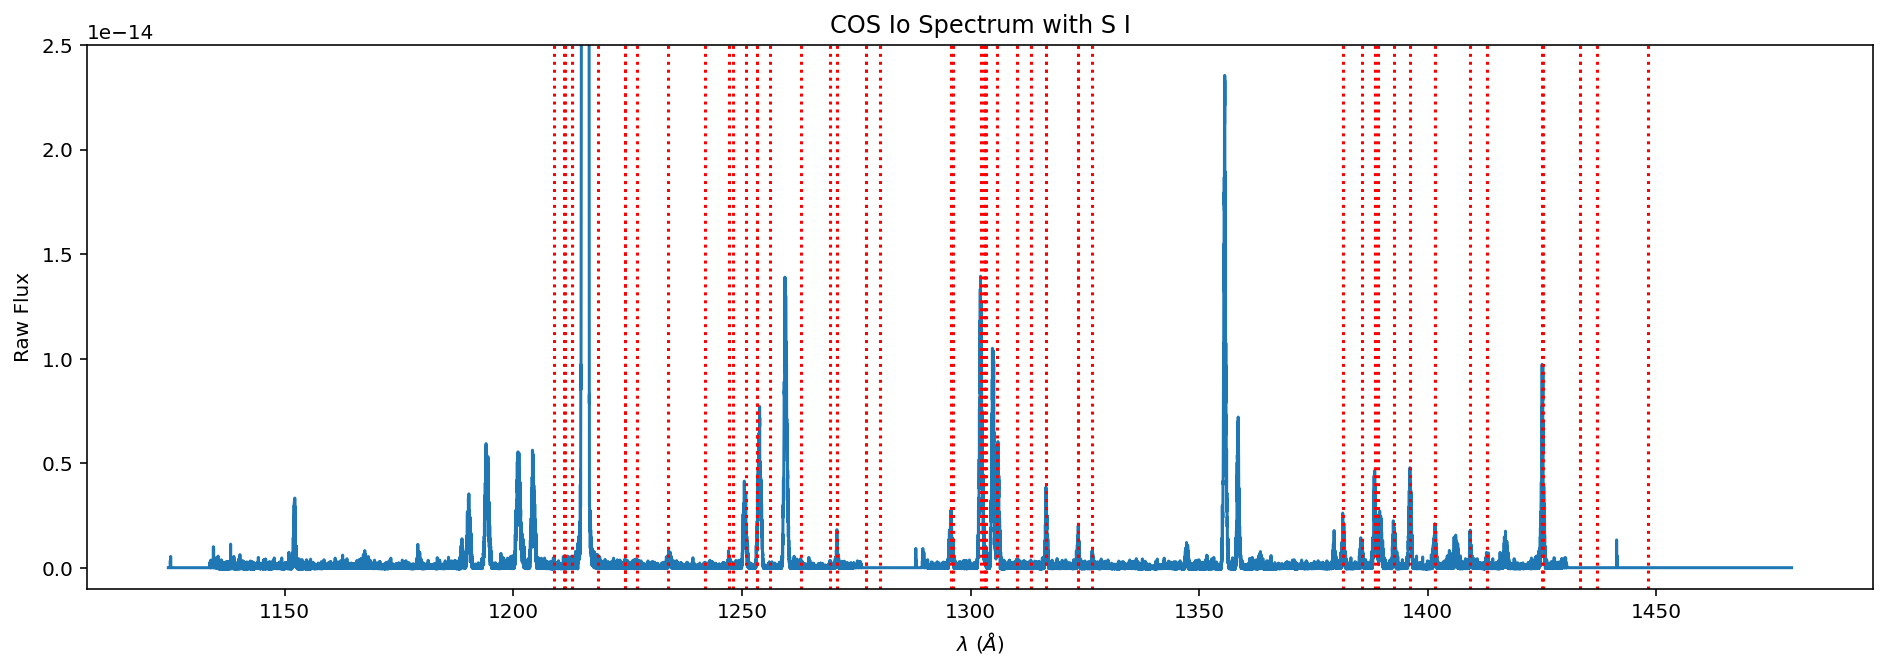

In [22]:
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum with S I")
plt.ylim(-0.01*10**-13,0.25*10**-13)
for xc in df_wavelength:
    plt.axvline(x=xc, color = 'red', linestyle = 'dotted')

In [41]:
wl = evt_data['WAVELENGTH']
flux = evt_data['FLUX']
wl_array = wl.data
flux_array = flux.data
wl_array = wl_array[0,:]
flux_array = flux_array[0,:]

Let's define the Gaussian model using the formula

$$B+A\exp\Bigg[-\Bigg(\frac{t-\mu}{\sigma}\Bigg)^2\Bigg]$$

In [69]:
# Classical Least Squares formula: Similarity vector calculation

def least_sq(sample_spectrum, components):
    
    # Sample_spectrum (unknown spectrum): array of w values.
    # Components (known spectra): array of n (number of components) columns with w values.
    # This def returns an array of n values. Each value is the similarity score for the sample_spectrum and a component spectrum.

    similarity = np.dot(inv(np.dot(components, components.T)) , np.dot(components, sample_spectrum))
    
    return similarity

In [70]:
# Gaussian function

def Gauss(x, mu, sigma, intensity = 1):
    
    # x is an array
    # mu is the expected value
    # sigma is the square root of the variance
    # intensity is a multiplication factor
    # This def returns the Gaussian function of x
    
    gaussian = intensity/(sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu)/sigma)**2)
    
    return gaussian

In [89]:
# Fabrication of our data:

# X-axis (Wavelengths)
x_range =  np.linspace(100, 200, 1000)

# Let's create three different components

# Component A
mu_a1 = 160
sigma_a1 = 4
intensity_a1 = 1

mu_a2 = 185
sigma_a2 = 2
intensity_a2 = 0.2

gauss_a =  Gauss(x_range, mu_a1, sigma_a1, intensity_a1) + Gauss(x_range, mu_a2, sigma_a2, intensity_a2)

# Component B
mu_b = 150
sigma_b = 15
intensity_b = 1
gauss_b = Gauss(x_range, mu_b, sigma_b, intensity_b)

# Component C
mu_c1 = 110
sigma_c1 = 2
intensity_c1 = 0.05

mu_c2 = 120
sigma_c2 = 10
intensity_c2 = 1

gauss_c = Gauss(x_range, mu_c1, sigma_c1, intensity_c1) + Gauss(x_range, mu_c2, sigma_c2, intensity_c2)

# Component normalization
component_a = gauss_a/np.max(gauss_a)
component_b = gauss_b/np.max(gauss_b)
component_c = gauss_c/np.max(gauss_c)

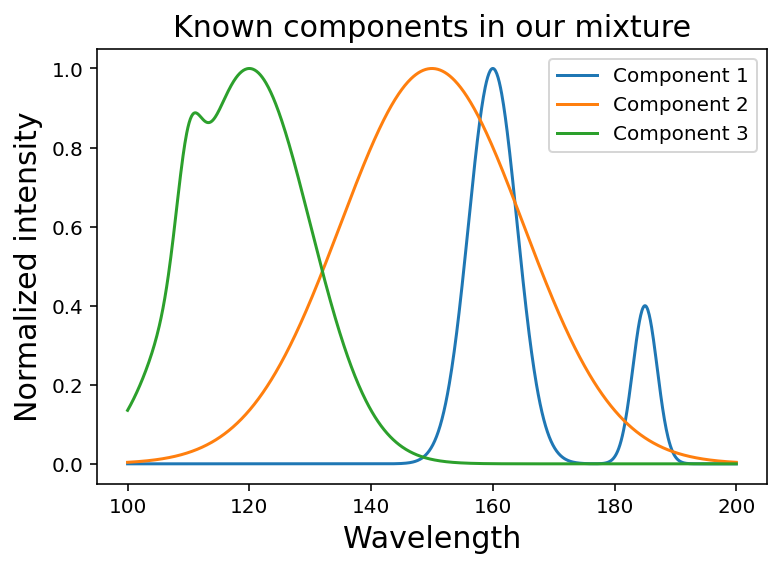

In [90]:
plt.plot(x_range, component_a, label = 'Component 1')
plt.plot(x_range, component_b, label = 'Component 2')
plt.plot(x_range, component_c, label = 'Component 3')
plt.title('Known components in our mixture', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Normalized intensity', fontsize = 15)
plt.legend()
plt.show()

In [91]:
# What concentrations we want these components to have in our mixture:
c_a = 0.5
c_b = 0.5
c_c = 0.5

# Let's build the spectrum to be studied: The mixture spectrum
query_spectra = c_a * component_a + c_b * component_b + c_c *component_c

# Let's add some noise for a bit of realism:
query_spectra = query_spectra +  np.random.normal(0, 0.02, len(x_range))

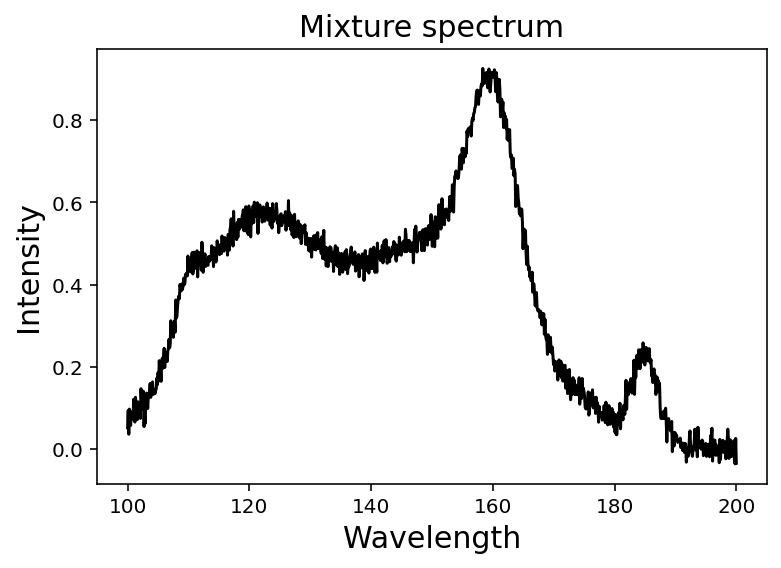

In [92]:
# How does it look?
plt.plot(x_range, query_spectra, color = 'black', label = 'Mixture spectrum with noise')
plt.title('Mixture spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

In [93]:
# Generate the components matrix or K matrix
components = np.array([component_a, component_b, component_c])

# Apply Least squares
cs = least_sq(query_spectra, components)

# And print the result:
print('The expected concentrations for components A, B and C are: ' + str(cs))

The expected concentrations for components A, B and C are: [0.50399624 0.49582098 0.49952045]


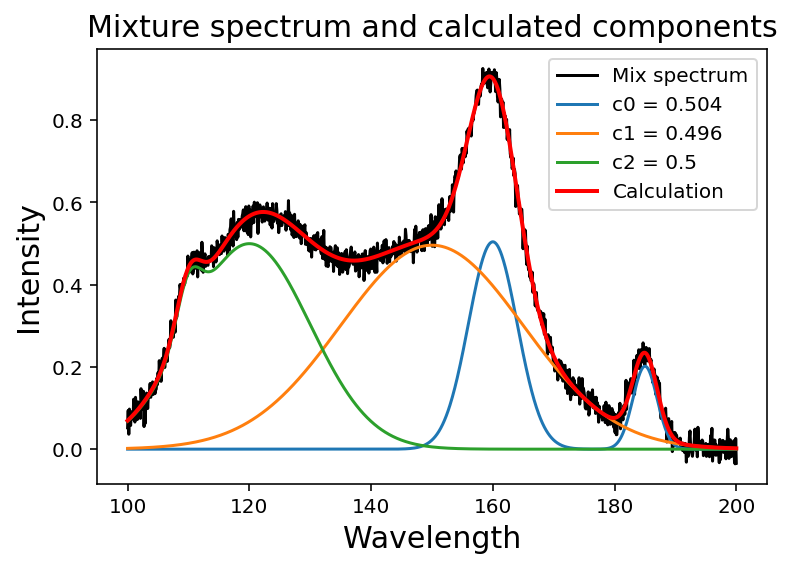

In [94]:
# Does the result match the original data?

# Plot the original data:
plt.plot(x_range, query_spectra, color = 'black', label = 'Mix spectrum' )

# Plot the separate components times its calculated concentration:
for i in np.arange(len(cs)):
    plt.plot(x_range, cs[i]*components[i], label = 'c' + str(i)+ ' = ' + str(np.round(cs[i], 3)))

# Plot the result: the sum of separate components times its calculated concentration:
plt.plot(x_range, np.dot(cs,components), color = 'red', linewidth = 2, label = 'Calculation')
    
plt.title('Mixture spectrum and calculated components', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity', fontsize = 15)
plt.legend()
plt.show()